In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.autonotebook import tqdm

import h5py
from PIL import Image
import os


from sklearn.model_selection import train_test_split
import random
from glob import glob
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
# import torch_directml

from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils import clip_grad_norm_

# device = torch_directml.device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
device

device(type='cpu')

In [3]:
seed=1010
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

batch_size = 32
num_classes = 1
epochs = 60
path = r'seg_model.pth'
path_images='./crack_segmentation_dataset/images/'
path_masks='./crack_segmentation_dataset/masks/'
images_paths = glob(path_images + '*.jpg')
masks_paths = glob(path_masks + '*.jpg')
images_paths = sorted([str(p) for p in images_paths])
masks_paths = sorted([str(p) for p in masks_paths])

df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})
train, test = train_test_split(df, test_size=.3, shuffle=True, random_state=seed)
train, valid = train_test_split(train, test_size=0.15, shuffle=True, random_state=seed)
print(f'Train size: {len(train)}, validation size: {len(valid)} and test size: {len(test)}')


Train size: 6721, validation size: 1187 and test size: 3390


In [65]:
resize_dim = 224  # This should be set based on your model's expected input

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((resize_dim, resize_dim)),  # Adjust this line to match the transformer's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [66]:
class CrackDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.df = dataframe
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        row = self.df.iloc[ix]
        image_path = row['images']
        mask_path = row['masks']

        # Load image using OpenCV and convert to RGB (OpenCV uses BGR by default)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Since ToPILImage is in the transformation, we can pass the ndarray directly
        # If you remove ToPILImage from transforms, convert image to PIL here:
        # image = Image.fromarray(image)

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (224, 224))  # Resize mask to match image size
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0  # Normalize mask

        if self.transforms:
            image = self.transforms(image)  # Apply transformations

        return image, mask

    def collate_fn(self, batch):
        images, masks = zip(*batch)
        images = torch.stack(images)
        masks = torch.stack(masks)
        return images, masks


In [67]:
# Initialize datasets
train_dataset = CrackDataset(train, transforms=train_transforms)
valid_dataset = CrackDataset(valid, transforms=train_transforms)

# Initialize DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)

In [68]:
class ViTForSegmentation(nn.Module):
    def __init__(self, num_classes, output_dim=(224, 224)):
        super(ViTForSegmentation, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
        self.segmentation_head = nn.Conv2d(768, num_classes, kernel_size=1)
        self.upsample = nn.Upsample(size=output_dim, mode='bilinear', align_corners=False)

    def forward(self, x):
        features = self.vit.vit(x).last_hidden_state

        batch_size, sequence_length, num_channels = features.size()
        # first token is the classification token and should be discarded for segmentation
        features = features[:, 1:, :]  # Skip the classification token

        side_length = int((sequence_length - 1)**0.5)  # Adjust for the removed classification token

        # Now the number of patches should form a perfect square
        assert side_length * side_length == (sequence_length - 1), "Number of patches does not form a perfect square"

        features = features.permute(0, 2, 1).reshape(batch_size, num_channels, side_length, side_length)

        # Apply the segmentation head and then upsample
        output = self.segmentation_head(features)
        output = self.upsample(output)
        return output

In [69]:
# Create the model
model = ViTForSegmentation(num_classes=1).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')


### Training

In [74]:
criterion = BCEWithLogitsLoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [75]:
def visualize_predictions(model, dataloader, device, num_images=1):
    model.eval()
    images, masks = next(iter(dataloader))  # Get a batch of images and masks
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        preds = model(images)
        preds = torch.sigmoid(preds) > 0.5  # Threshold the predictions to obtain binary mask

    images_np = images.cpu().numpy()
    masks_np = masks.cpu().numpy()
    preds_np = preds.cpu().numpy()

    for i in range(num_images):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(images_np[i], (1, 2, 0)))  # Assuming images are [C, H, W]
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(masks_np[i].squeeze(), cmap='gray')
        plt.title('Original Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(preds_np[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

In [76]:
def train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs=60, patience=10):
    best_val_loss = float('inf')
    writer = SummaryWriter('./runs/')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    epochs_no_improve = 0
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-6, factor=0.1)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        train_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for images, masks in train_bar:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            # Apply gradient clipping
            clip_grad_norm_(model.parameters(), max_norm=1.0)


            running_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs) > 0.5  # Binarize predictions
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

            train_bar.set_postfix(loss=(running_loss / total_pixels), accuracy=(correct_pixels / total_pixels), refresh=False)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_accuracy = correct_pixels / total_pixels
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        writer.add_scalar('Loss/Train', epoch_loss, epoch)
        writer.add_scalar('Accuracy/Train', epoch_accuracy, epoch)

        model.eval()
        val_running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0
        visualize_predictions(model, valid_dataloader, device, num_images=1)

        valid_bar = tqdm(valid_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        with torch.no_grad():
            for images, masks in valid_bar:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item() * images.size(0)
                preds = torch.sigmoid(outputs) > 0.5  # Binarize predictions
                correct_pixels += (preds == masks).sum().item()
                total_pixels += masks.numel()

                valid_bar.set_postfix(loss=(val_running_loss / total_pixels), accuracy=(correct_pixels / total_pixels), refresh=False)

        val_epoch_loss = val_running_loss / len(valid_dataloader.dataset)
        val_epoch_accuracy = correct_pixels / total_pixels
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        # Log validation metrics
        writer.add_scalar('Loss/Valid', val_epoch_loss, epoch)
        writer.add_scalar('Accuracy/Valid', val_epoch_accuracy, epoch)

        scheduler.step(val_epoch_loss)

        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            checkpoint_path = f'./checkpoint/model_{val_epoch_loss:.4f}_{epoch_loss:.4f}__{val_epoch_accuracy:.4f}.pth'
            torch.save(model.state_dict(), checkpoint_path)

        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break
    writer.close()

    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/30:   0%|          | 0/210 [00:00<?, ?it/s]

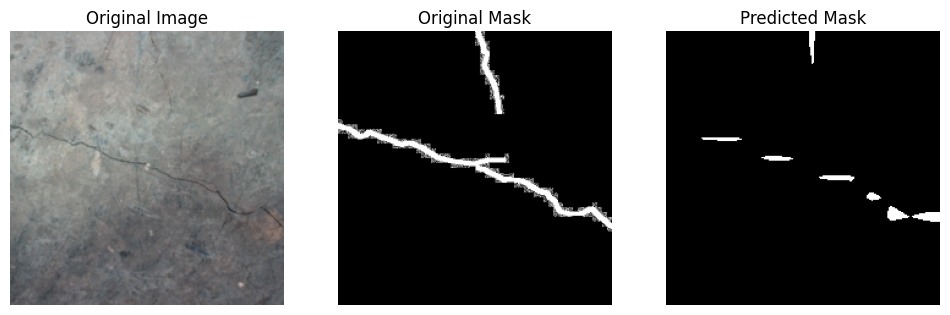

Epoch 1/30:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/210 [00:00<?, ?it/s]

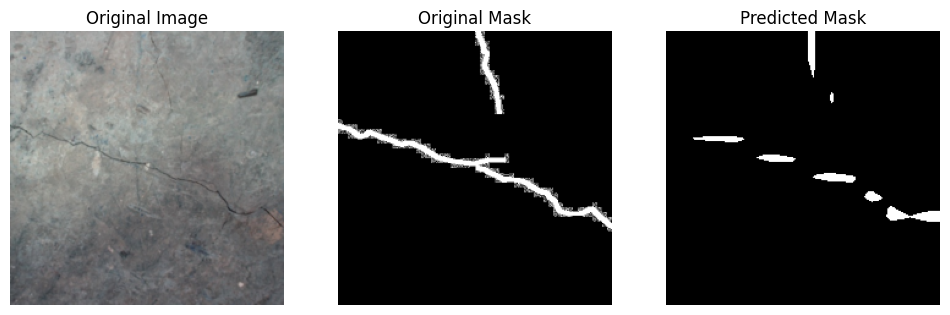

Epoch 2/30:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/210 [00:00<?, ?it/s]

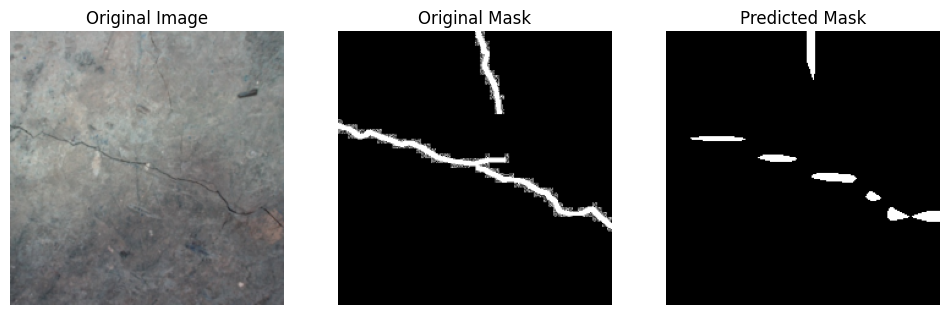

Epoch 3/30:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/210 [00:00<?, ?it/s]

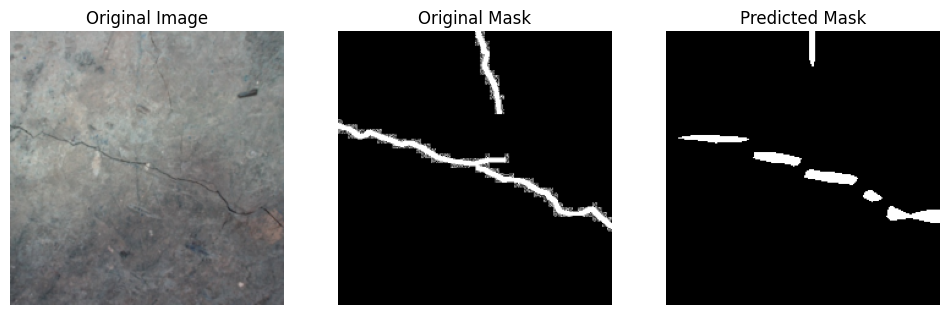

Epoch 4/30:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/210 [00:00<?, ?it/s]

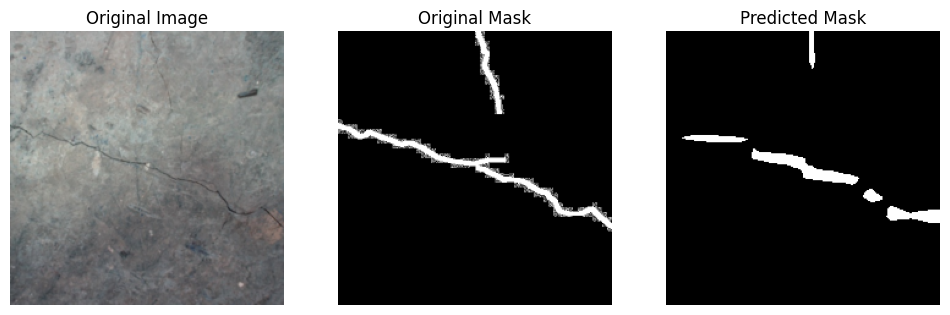

Epoch 5/30:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/210 [00:00<?, ?it/s]

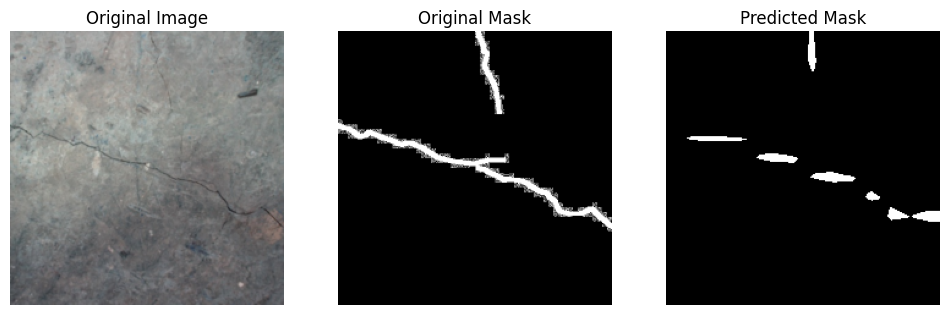

Epoch 6/30:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/210 [00:00<?, ?it/s]

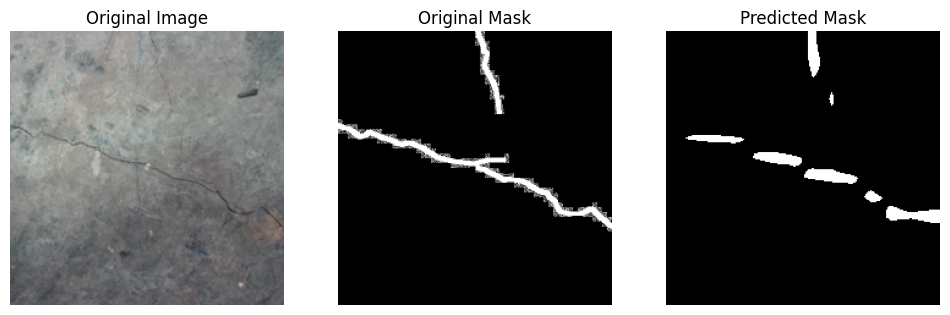

Epoch 7/30:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/210 [00:00<?, ?it/s]

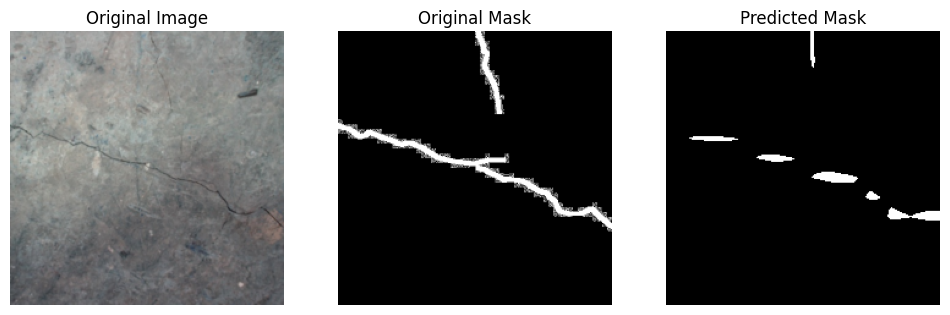

Epoch 8/30:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/210 [00:00<?, ?it/s]

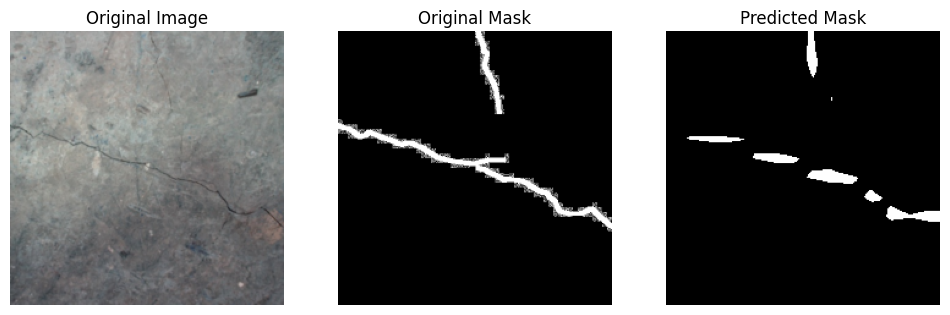

Epoch 9/30:   0%|          | 0/37 [00:00<?, ?it/s]

Early stopping triggered


In [77]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs=30, patience=5)

In [78]:
with h5py.File('training_metrics.h5', 'w') as f:
    f.create_dataset('train_losses', data=np.array(train_losses))
    f.create_dataset('val_losses', data=np.array(val_losses))
    f.create_dataset('train_accuracies', data=np.array(train_accuracies))
    f.create_dataset('val_accuracies', data=np.array(val_accuracies))

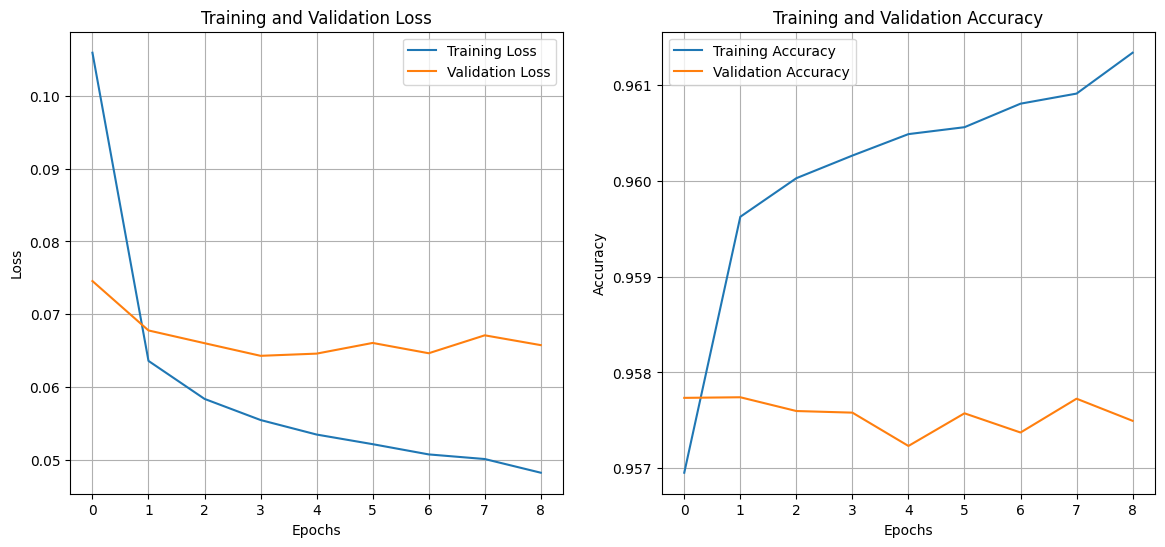

In [79]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

# Run the training function

# Plot the training and validation losses and accuracies
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


### Loading the model

In [81]:
def load_model(model_path, device):
    model = ViTForSegmentation(num_classes=1).to(device)  # Ensure the architecture is correctly initialized
    state_dict = torch.load(model_path, map_location=device)
    
    # Filter out classifier weights if they exist in the checkpoint and you don't need them
    state_dict = {k: v for k, v in state_dict.items() if not k.startswith('classifier.')}
    
    model.load_state_dict(state_dict, strict=False)  
    model.eval()
    return model

# Example: Load a specific checkpoint (adjust the path as needed)
model_path = 'checkpoint\model_0.0678_0.0636__0.9577.pth'
model = load_model(model_path, device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
def evaluate_model(model, dataloader, device):
    k=1
    model.eval()
    ious = []
    dices = []

    with torch.no_grad():
        for i, (images, true_masks) in enumerate(dataloader):
            print(f"Processing batch {i+1}/{len(dataloader)}")  # Debug: print current batch
            images, true_masks = images.to(device), true_masks.to(device)
            pred_masks = model(images)
            
            pred_masks = torch.sigmoid(pred_masks) > 0.5
            pred_masks = pred_masks.bool()
            true_masks = true_masks.bool()

            intersection = (pred_masks & true_masks).float().sum((1, 2, 3))
            union = (pred_masks | true_masks).float().sum((1, 2, 3))
            iou = (intersection + 1e-6) / (union + 1e-6)  # iou is now a single scalar per batch
            dice = (2 * intersection + 1e-6) / (pred_masks.float().sum((1, 2, 3)) + true_masks.float().sum((1, 2, 3)) + 1e-6)  # dice is now a single scalar per batch

            k+=1
            ious.append(iou.cpu().numpy())  # Move to CPU after computation
            dices.append(dice.cpu().numpy())
            if k==105:
                break

    avg_iou = np.mean(ious)
    avg_dice = np.mean(dices)
    return avg_iou, avg_dice


In [163]:
def show_predictions(model, dataloader, device, num_examples=3):
    model.eval()
    images, masks = next(iter(dataloader))  # Get a batch of images and masks
    images, masks = images.to(device), masks.to(device)
    preds = model(images)
    preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities

    plt.figure(figsize=(15, num_examples * 3))  # Increase width for 4 images per row
    for i in range(num_examples):
        # Display Input Image
        plt.subplot(num_examples, 4, i * 4 + 1)
        img = images[i].cpu().detach().permute(1, 2, 0)
        plt.imshow(img)
        plt.title("Input Image")
        # plt.axis('off')

        # Display Ground Truth Mask
        plt.subplot(num_examples, 4, i * 4 + 2)
        plt.imshow(masks[i].cpu().detach().squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        # plt.axis('off')

        # Display Predicted Mask
        plt.subplot(num_examples, 4, i * 4 + 3)
        pred = (preds[i].cpu().detach().squeeze() > 0.2)
        plt.imshow(pred, cmap='gray')
        plt.title("Predicted Mask")
        # plt.axis('off')

        # Display Overlay of Predicted Mask on Input Image
        plt.subplot(num_examples, 4, i * 4 + 4)
        plt.imshow(img)
        plt.imshow(pred, alpha=0.5, cmap='Greens')  # Red tinted prediction overlay
        plt.title("Prediction Overlay")
        # plt.axis('off')

    plt.tight_layout()
    plt.show()


In [85]:
test_dataset = CrackDataset(test, transforms=train_transforms)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Assuming test_dataset is prepared




In [96]:
images, masks = next(iter(test_dataloader))  # Get a batch of images and masks
images, masks = images.to(device), masks.to(device)

In [98]:
images.shape

torch.Size([32, 3, 224, 224])

In [89]:
# Evaluate the model
avg_iou, avg_dice = evaluate_model(model, test_dataloader, device)


Processing batch 1/106
Processing batch 2/106
Processing batch 3/106
Processing batch 4/106
Processing batch 5/106
Processing batch 6/106
Processing batch 7/106
Processing batch 8/106
Processing batch 9/106
Processing batch 10/106
Processing batch 11/106
Processing batch 12/106
Processing batch 13/106
Processing batch 14/106
Processing batch 15/106
Processing batch 16/106
Processing batch 17/106
Processing batch 18/106
Processing batch 19/106
Processing batch 20/106
Processing batch 21/106
Processing batch 22/106
Processing batch 23/106
Processing batch 24/106
Processing batch 25/106
Processing batch 26/106
Processing batch 27/106
Processing batch 28/106
Processing batch 29/106
Processing batch 30/106
Processing batch 31/106
Processing batch 32/106
Processing batch 33/106
Processing batch 34/106
Processing batch 35/106
Processing batch 36/106
Processing batch 37/106
Processing batch 38/106
Processing batch 39/106
Processing batch 40/106
Processing batch 41/106
Processing batch 42/106
P

Average IoU: 0.3229, Average Dice: 0.3991


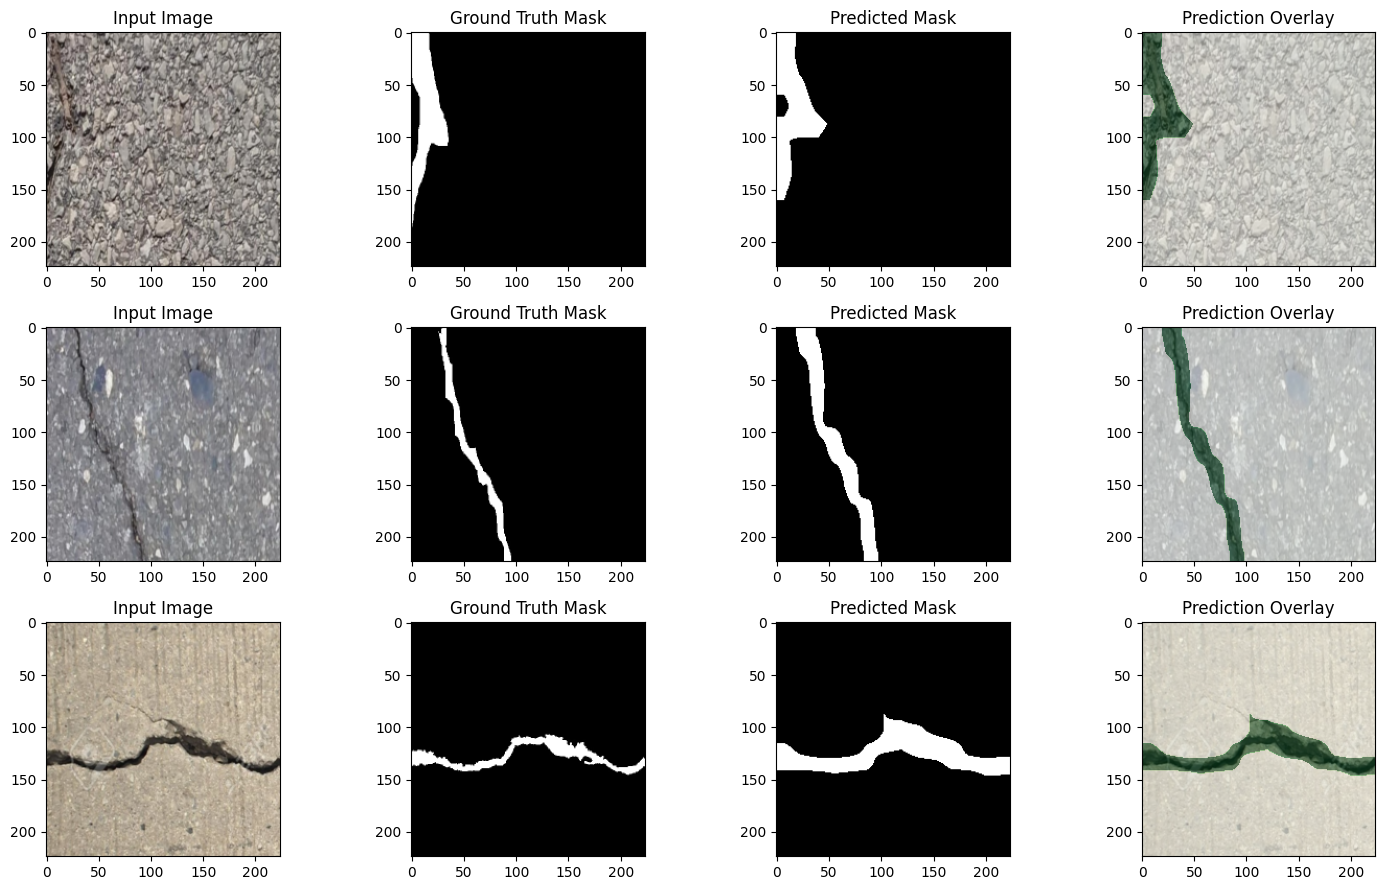

In [164]:
print(f"Average IoU: {avg_iou:.4f}, Average Dice: {avg_dice:.4f}")

# Show some predictions
show_predictions(model, test_dataloader, device, num_examples=3)

### Saving the model

In [99]:
example_input = torch.rand(1, 3, 224, 224).to(device)
traced_model = torch.jit.trace(model, example_input)
torch.jit.save(traced_model, 'model_traced.imp_pth')


In [3]:
loaded_traced_model = torch.jit.load("model_traced.imp_pth",map_location=torch.device(device))
image_path='./a.jpeg'
image = Image.open(image_path).convert('RGB')


In [4]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(loaded_traced_model)

+-----------------------------------------------------------+------------+
|                          Modules                          | Parameters |
+-----------------------------------------------------------+------------+
|                vit.vit.embeddings.cls_token               |    768     |
|           vit.vit.embeddings.position_embeddings          |   151296   |
|   vit.vit.embeddings.patch_embeddings.projection.weight   |   589824   |
|    vit.vit.embeddings.patch_embeddings.projection.bias    |    768     |
|  vit.vit.encoder.layer.0.attention.attention.query.weight |   589824   |
|   vit.vit.encoder.layer.0.attention.attention.query.bias  |    768     |
|   vit.vit.encoder.layer.0.attention.attention.key.weight  |   589824   |
|    vit.vit.encoder.layer.0.attention.attention.key.bias   |    768     |
|  vit.vit.encoder.layer.0.attention.attention.value.weight |   589824   |
|   vit.vit.encoder.layer.0.attention.attention.value.bias  |    768     |
|   vit.vit.encoder.layer

85800963

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size that the model expects
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

In [11]:
image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to(device)


In [12]:
with torch.no_grad():
    output = loaded_traced_model(image_tensor)
    pred_mask = torch.sigmoid(output)

pred_mask_np = pred_mask.squeeze().cpu().numpy()


(-0.5, 223.5, 223.5, -0.5)

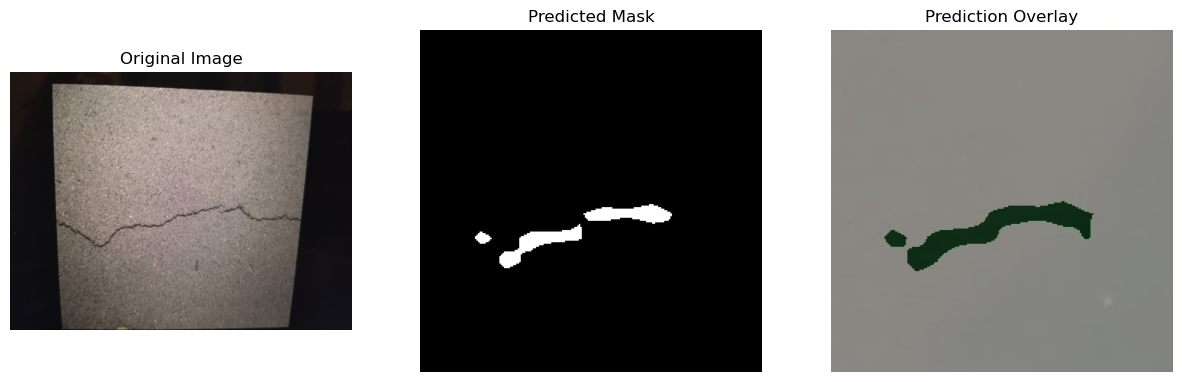

In [14]:
# image_pil = transforms.ToPILImage()(image_tensor.squeeze(0))  # Squeeze to remove batch dim

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Predicted mask
axs[1].imshow(pred_mask_np >0.3 , cmap='gray')
axs[1].set_title('Predicted Mask')
axs[1].axis('off')

axs[2].imshow(image)# Red tinted prediction overlay
axs[2].imshow(pred_mask_np >0.2, alpha=0.5, cmap='Greens')
axs[2].set_title("Prediction Overlay")
axs[2].axis('off')
